# Exploring Stock Price-Volume Dataset

Quick exploration of the Kaggle dataset: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/

Understanding the data structure before building RL trading strategies.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Setup Kaggle API


In [2]:
api = KaggleApi()
api.authenticate()
print("Kaggle API authenticated")


Kaggle API authenticated


## Download Dataset


In [3]:
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

DATASET_NAME = 'borismarjanovic/price-volume-data-for-all-us-stocks-etfs'
api.dataset_download_files(DATASET_NAME, path=DATA_DIR, unzip=True)
print(f"Dataset downloaded to {DATA_DIR}")


Dataset URL: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
Dataset downloaded to data


## Dataset Structure


In [12]:
items = list(DATA_DIR.iterdir())
files = [item for item in items if item.is_file()]
dirs = [item for item in items if item.is_dir()]

if dirs:
    print("Directories:")
    for d in sorted(dirs):
        size = sum(f.stat().st_size for f in d.rglob('*') if f.is_file())
        print(f"  {d.name}/ ({size / (1024**2):.2f} MB)")

if files:
    print("\nFiles:")
    for f in sorted(files):
        size = f.stat().st_size / (1024**2)
        print(f"  {f.name} ({size:.2f} MB)")


Directories:
  Data/ (771.54 MB)
  ETFs/ (115.02 MB)
  Stocks/ (656.53 MB)


## Find Data Files


In [13]:
# Files are .txt but contain CSV data
data_files = list(DATA_DIR.rglob('*.txt')) + list(DATA_DIR.rglob('*.csv'))
print(f"Found {len(data_files)} data files")

if data_files:
    print("\nFirst 20 files:")
    for i, f in enumerate(data_files[:20], 1):
        size = f.stat().st_size / (1024**2)
        print(f"{i:2d}. {f.relative_to(DATA_DIR)} ({size:.2f} MB)")
    
    if len(data_files) > 20:
        print(f"\n... and {len(data_files) - 20} more files")
    
    # Group by directories
    dir_structure = {}
    for f in data_files:
        parent = f.parent.relative_to(DATA_DIR)
        if parent not in dir_structure:
            dir_structure[parent] = []
        dir_structure[parent].append(f)
    
    print("\nDirectory structure:")
    for dir_path, files in sorted(dir_structure.items()):
        print(f"\n{dir_path}/ ({len(files)} files)")
        if len(files) <= 5:
            for f in files:
                print(f"  {f.name}")
        else:
            for f in files[:3]:
                print(f"  {f.name}")
            print(f"  ... and {len(files) - 3} more")


Found 17078 data files

First 20 files:
 1. Stocks/iba.us.txt (0.14 MB)
 2. Stocks/wpz.us.txt (0.14 MB)
 3. Stocks/opnt.us.txt (0.00 MB)
 4. Stocks/indf.us.txt (0.02 MB)
 5. Stocks/flic.us.txt (0.14 MB)
 6. Stocks/nbhc.us.txt (0.06 MB)
 7. Stocks/ncs.us.txt (0.13 MB)
 8. Stocks/grvy.us.txt (0.12 MB)
 9. Stocks/lgcyo.us.txt (0.04 MB)
10. Stocks/eqco.us.txt (0.06 MB)
11. Stocks/gpk.us.txt (0.15 MB)
12. Stocks/wti.us.txt (0.14 MB)
13. Stocks/dyn_a.us.txt (0.03 MB)
14. Stocks/cstr.us.txt (0.01 MB)
15. Stocks/mygn.us.txt (0.14 MB)
16. Stocks/cor_a-cl.us.txt (0.00 MB)
17. Stocks/jmu.us.txt (0.02 MB)
18. Stocks/jpem.us.txt (0.03 MB)
19. Stocks/kelya.us.txt (0.15 MB)
20. Stocks/wbig.us.txt (0.04 MB)

... and 17058 more files

Directory structure:

Data/ETFs/ (1344 files)
  vti.us.txt
  ibnd.us.txt
  viov.us.txt
  ... and 1341 more

Data/Stocks/ (7195 files)
  iba.us.txt
  wpz.us.txt
  opnt.us.txt
  ... and 7192 more

ETFs/ (1344 files)
  vti.us.txt
  ibnd.us.txt
  viov.us.txt
  ... and 1341 mo

## Sample Data Structure


In [14]:
if data_files:
    sample_file = data_files[0]
    print(f"Analyzing: {sample_file.name}")
    
    # Try different separators
    for sep in [',', ';', '\t']:
        try:
            df_sample = pd.read_csv(sample_file, sep=sep, nrows=5)
            if len(df_sample.columns) > 1:
                print(f"Loaded with separator '{sep}'")
                break
        except:
            continue
    
    print(f"\nShape: {df_sample.shape}")
    print(f"Columns: {list(df_sample.columns)}")
    print("\nFirst rows:")
    print(df_sample.head())
    print("\nData types:")
    print(df_sample.dtypes)
    print("\nBasic stats:")
    print(df_sample.describe())


Analyzing: iba.us.txt
Loaded with separator ','

Shape: (5, 7)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

First rows:
         Date    Open    High     Low   Close  Volume  OpenInt
0  2005-02-25  12.868  12.982  12.834  12.834   15928        0
1  2005-02-28  13.536  13.536  13.273  13.281   16382        0
2  2005-03-01  13.185  13.299  13.185  13.299    1250        0
3  2005-03-02  13.361  13.395  13.273  13.291    8760        0
4  2005-03-03  13.361  13.404  12.966  13.218    9897        0

Data types:
Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object

Basic stats:
            Open       High        Low      Close        Volume  OpenInt
count   5.000000   5.000000   5.000000   5.000000      5.000000      5.0
mean   13.262200  13.323200  13.106200  13.184600  10443.400000      0.0
std     0.252905   0.208549   0.197233   0.198581   6184.634169      0.0
min    12

## Load Full Sample File


In [15]:
if data_files:
    sample_file = data_files[0]
    
    with open(sample_file, 'r') as f:
        first_line = f.readline()
        sep = ',' if ',' in first_line else (';' if ';' in first_line else '\t')
    
    print(f"Loading {sample_file.name}...")
    df_full = pd.read_csv(sample_file, sep=sep)
    
    print(f"Loaded: {df_full.shape[0]:,} rows × {df_full.shape[1]} columns")
    print(f"Memory: {df_full.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    
    print("\nInfo:")
    print(df_full.info())
    
    print("\nFirst 10 rows:")
    print(df_full.head(10))
    
    print("\nLast 10 rows:")
    print(df_full.tail(10))
    
    missing = df_full.isnull().sum()
    if missing.sum() > 0:
        print("\nMissing values:")
        print(missing[missing > 0])
    else:
        print("\nNo missing values")
    
    duplicates = df_full.duplicated().sum()
    print(f"\nDuplicates: {duplicates}")


Loading iba.us.txt...
Loaded: 3,199 rows × 7 columns
Memory: 0.33 MB

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3199 non-null   object 
 1   Open     3199 non-null   float64
 2   High     3199 non-null   float64
 3   Low      3199 non-null   float64
 4   Close    3199 non-null   float64
 5   Volume   3199 non-null   int64  
 6   OpenInt  3199 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 175.1+ KB
None

First 10 rows:
         Date    Open    High     Low   Close  Volume  OpenInt
0  2005-02-25  12.868  12.982  12.834  12.834   15928        0
1  2005-02-28  13.536  13.536  13.273  13.281   16382        0
2  2005-03-01  13.185  13.299  13.185  13.299    1250        0
3  2005-03-02  13.361  13.395  13.273  13.291    8760        0
4  2005-03-03  13.361  13.404  12.966  13.218    9897        0
5  2005-03-04

## Time Series Analysis


In [16]:
if 'df_full' in locals() and df_full is not None:
    # Find date columns
    date_columns = []
    for col in df_full.columns:
        col_lower = str(col).lower()
        if any(kw in col_lower for kw in ['date', 'time', 'timestamp', 'day']):
            date_columns.append(col)
    
    if date_columns:
        print(f"Date columns: {date_columns}")
        for date_col in date_columns:
            df_full[date_col] = pd.to_datetime(df_full[date_col], errors='coerce')
            print(f"\n{date_col}:")
            print(f"  First: {df_full[date_col].min()}")
            print(f"  Last: {df_full[date_col].max()}")
            print(f"  Unique dates: {df_full[date_col].nunique()}")
            print(f"  Missing: {df_full[date_col].isnull().sum()}")
            
            date_diff = df_full[date_col].diff().dropna()
            if len(date_diff) > 0:
                print(f"  Avg interval: {date_diff.mean()}")
    
    # Find price columns
    price_columns = []
    for col in df_full.columns:
        col_lower = str(col).lower()
        if any(kw in col_lower for kw in ['price', 'close', 'open', 'high', 'low', 'adj']):
            price_columns.append(col)
    
    if price_columns:
        print(f"\nPrice columns: {price_columns}")
        for col in price_columns:
            print(f"\n{col}:")
            print(f"  Min: {df_full[col].min():.2f}")
            print(f"  Max: {df_full[col].max():.2f}")
            print(f"  Mean: {df_full[col].mean():.2f}")
            print(f"  Std: {df_full[col].std():.2f}")
    
    # Find volume columns
    volume_columns = []
    for col in df_full.columns:
        if 'volume' in str(col).lower():
            volume_columns.append(col)
    
    if volume_columns:
        print(f"\nVolume columns: {volume_columns}")
        for col in volume_columns:
            print(f"\n{col}:")
            print(f"  Min: {df_full[col].min():,.0f}")
            print(f"  Max: {df_full[col].max():,.0f}")
            print(f"  Mean: {df_full[col].mean():,.0f}")
            print(f"  Median: {df_full[col].median():,.0f}")


Date columns: ['Date']

Date:
  First: 2005-02-25 00:00:00
  Last: 2017-11-10 00:00:00
  Unique dates: 3199
  Missing: 0
  Avg interval: 1 days 10:49:45.365853658

Price columns: ['Open', 'High', 'Low', 'Close', 'OpenInt']

Open:
  Min: 7.95
  Max: 67.49
  Mean: 30.32
  Std: 14.95

High:
  Min: 8.26
  Max: 67.61
  Mean: 30.71
  Std: 15.08

Low:
  Min: 7.55
  Max: 66.50
  Mean: 29.93
  Std: 14.83

Close:
  Min: 7.94
  Max: 67.61
  Mean: 30.33
  Std: 14.96

OpenInt:
  Min: 0.00
  Max: 0.00
  Mean: 0.00
  Std: 0.00

Volume columns: ['Volume']

Volume:
  Min: 112
  Max: 321,163
  Mean: 17,676
  Median: 12,166


## Visualizations


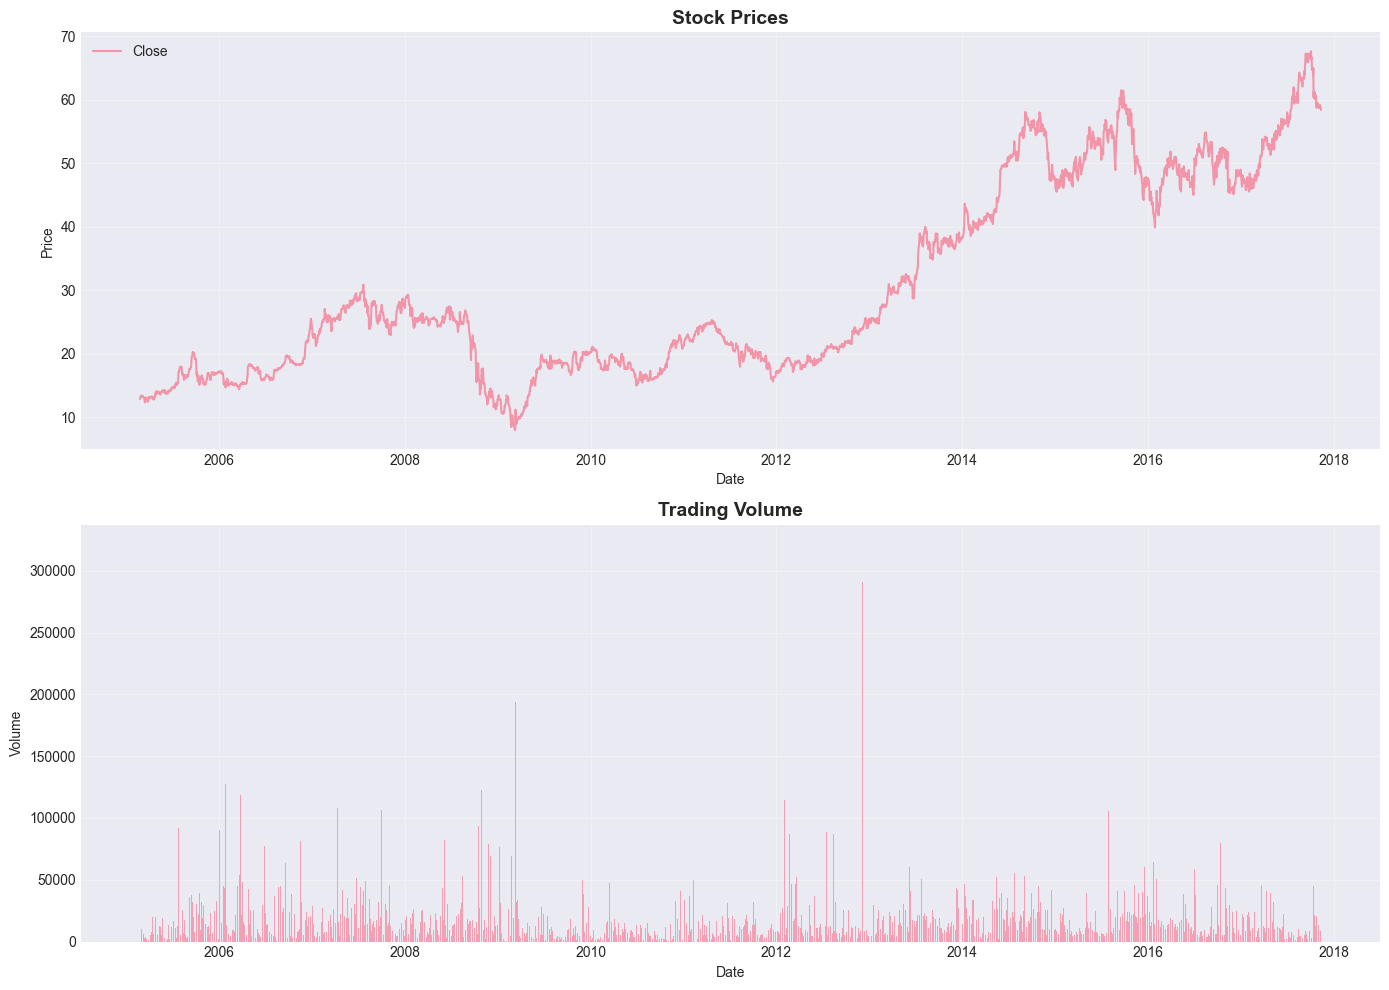

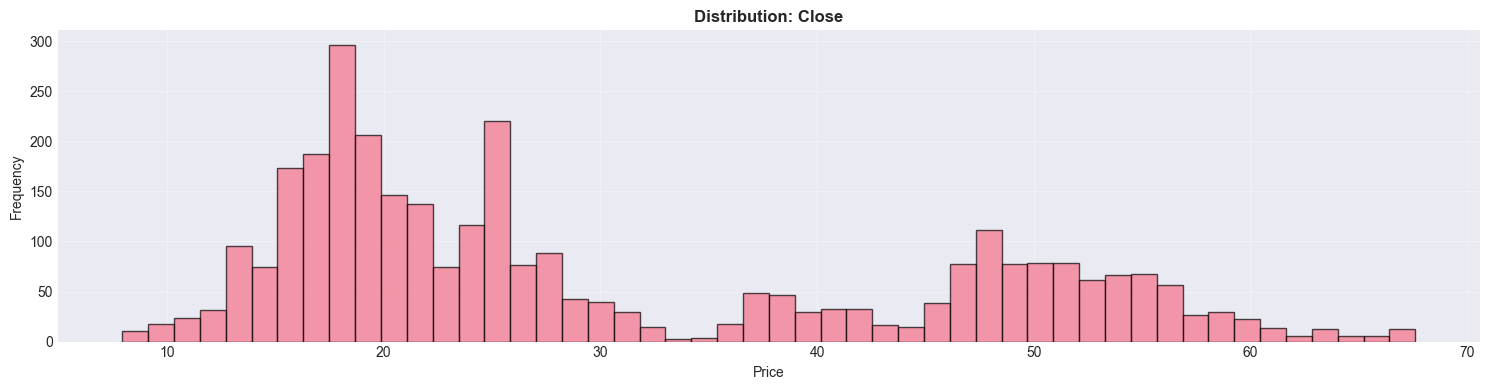

In [17]:
if 'df_full' in locals() and df_full is not None:
    date_col = None
    price_cols = []
    volume_col = None
    
    for col in df_full.columns:
        col_lower = str(col).lower()
        if not date_col and any(kw in col_lower for kw in ['date', 'time']):
            date_col = col
        if any(kw in col_lower for kw in ['close', 'price', 'adj close']):
            price_cols.append(col)
        if not volume_col and 'volume' in col_lower:
            volume_col = col
    
    if date_col and price_cols:
        if not pd.api.types.is_datetime64_any_dtype(df_full[date_col]):
            df_full[date_col] = pd.to_datetime(df_full[date_col], errors='coerce')
        
        df_plot = df_full.sort_values(date_col).copy()
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        for price_col in price_cols[:3]:
            axes[0].plot(df_plot[date_col], df_plot[price_col], label=price_col, alpha=0.7)
        axes[0].set_title('Stock Prices', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Price')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        if volume_col:
            axes[1].bar(df_plot[date_col], df_plot[volume_col], alpha=0.6, width=1)
            axes[1].set_title('Trading Volume', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Date')
            axes[1].set_ylabel('Volume')
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        if price_cols:
            fig, axes = plt.subplots(1, min(3, len(price_cols)), figsize=(15, 4))
            if len(price_cols) == 1:
                axes = [axes]
            
            for idx, price_col in enumerate(price_cols[:3]):
                axes[idx].hist(df_full[price_col].dropna(), bins=50, alpha=0.7, edgecolor='black')
                axes[idx].set_title(f'Distribution: {price_col}', fontsize=12, fontweight='bold')
                axes[idx].set_xlabel('Price')
                axes[idx].set_ylabel('Frequency')
                axes[idx].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()


## Compare File Structures


In [18]:
if data_files and len(data_files) > 1:
    sample_files = data_files[:min(5, len(data_files))]
    file_structures = {}
    
    for file_path in sample_files:
        try:
            with open(file_path, 'r') as f:
                first_line = f.readline()
                sep = ',' if ',' in first_line else (';' if ';' in first_line else '\t')
            
            df_temp = pd.read_csv(file_path, sep=sep, nrows=0)
            file_structures[file_path.name] = {
                'columns': list(df_temp.columns),
                'num_columns': len(df_temp.columns)
            }
        except Exception as e:
            file_structures[file_path.name] = {'error': str(e)}
    
    for filename, structure in file_structures.items():
        print(f"\n{filename}:")
        if 'error' in structure:
            print(f"  Error: {structure['error']}")
        else:
            print(f"  Columns: {structure['num_columns']}")
            print(f"  {structure['columns']}")
    
    if all('columns' in s for s in file_structures.values()):
        all_columns = [s['columns'] for s in file_structures.values()]
        if len(set(tuple(cols) for cols in all_columns)) == 1:
            print("\nAll files have the same structure!")
        else:
            print("\nFiles have different column structures")



iba.us.txt:
  Columns: 7
  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

wpz.us.txt:
  Columns: 7
  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

opnt.us.txt:
  Columns: 7
  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

indf.us.txt:
  Columns: 7
  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

flic.us.txt:
  Columns: 7
  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

All files have the same structure!


## Summary


In [19]:
if data_files:
    total_size = sum(f.stat().st_size for f in data_files) / (1024**3)
    print(f"Total data files: {len(data_files)}")
    print(f"Total size: {total_size:.2f} GB")
    
    if 'df_full' in locals() and df_full is not None:
        print(f"\nData structure (sample file):")
        print(f"  Columns: {list(df_full.columns)}")
        print(f"\n  Data types:")
        for col, dtype in df_full.dtypes.items():
            print(f"    {col}: {dtype}")
        
        print(f"\nFor RL strategies, we'll need:")
        needed_cols = []
        for col in df_full.columns:
            col_lower = str(col).lower()
            if any(kw in col_lower for kw in ['date', 'time']):
                needed_cols.append(f"  Date/time: {col}")
            if any(kw in col_lower for kw in ['close', 'price']):
                needed_cols.append(f"  Close price: {col}")
            if 'volume' in col_lower:
                needed_cols.append(f"  Volume: {col}")
        
        for item in needed_cols:
            print(item)
        
        print(f"\nNext steps:")
        print(f"  - Preprocess data (normalize, create features)")
        print(f"  - Create RL environment")
        print(f"  - Implement agent and strategy")


Total data files: 17078
Total size: 1.51 GB

Data structure (sample file):
  Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

  Data types:
    Date: datetime64[ns]
    Open: float64
    High: float64
    Low: float64
    Close: float64
    Volume: int64
    OpenInt: int64

For RL strategies, we'll need:
  Date/time: Date
  Close price: Close
  Volume: Volume

Next steps:
  - Preprocess data (normalize, create features)
  - Create RL environment
  - Implement agent and strategy
